In [1]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os
import gzip
import numpy as np
import scanpy as sc
import squidpy as sq
import cupy as cp
import cupyx
from cupyx.scipy.sparse import csr_matrix 
import os
import time
import rapids_singlecell as rsc
import numpy as np
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
import cupy
rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)
import zarr
import pickle
from collections import OrderedDict
from scipy.sparse import csr_matrix
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from scipy.sparse import csr_matrix
import scipy
import anndata
from collections import OrderedDict
from rsc_functions.utility.applyqc import applyqc
from rsc_functions.reports.plot import plot_spatial,plot_spatial_data, plot_dist

<center>Breast Cancer IF </center>

In [5]:
path_016 = "/data/kanferg/Sptial_Omics/playGround/Data/Breast_Cancer/age_58/binned_outputs/square_016um"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_4"

In [6]:
def parquet_to_csv(path):
    '''
    Converts a Parquet file to a CSV file if the CSV file does not already exist.
    '''
    file_path = os.path.join(path,'spatial/tissue_positions_list.csv')
    if not os.path.exists(file_path):
        df = pd.read_parquet(os.path.join(path,'spatial/tissue_positions.parquet'))
        # Write to a CSV file
        df.to_csv(os.path.join(path,'spatial/tissue_positions_list.csv'), index=False)
    return
parquet_to_csv(path_016)

In [7]:
andata = sc.read_visium(path=path_016,load_images=False)
positions = pd.read_csv(os.path.join(path_016,'spatial/tissue_positions_list.csv'),index_col=0,)
positions.columns = [
            "in_tissue",
            "array_row",
            "array_col",
            "pxl_col_in_fullres",
            "pxl_row_in_fullres",
        ]
andata.obs = andata.obs.join(positions, how="left")
andata.obsm["spatial"] = andata.obs[
            ["pxl_row_in_fullres", "pxl_col_in_fullres"]
        ].to_numpy()
andata.obs.drop(
    columns=["pxl_row_in_fullres", "pxl_col_in_fullres"],
    inplace=True,
)

/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [8]:
rsc.get.anndata_to_GPU(andata)
andata.obsm['spatial'] = np.array(andata.obsm['spatial'], dtype=np.float64)
andata.var_names_make_unique()
andata.uns['config'] = OrderedDict()
andata.uns["config"]["secondary_var_names"] = andata.var_names
rsc.pp.flag_gene_family(andata, gene_family_name="MT", gene_family_prefix="MT-")
rsc.pp.calculate_qc_metrics(andata, qc_vars=["MT"])

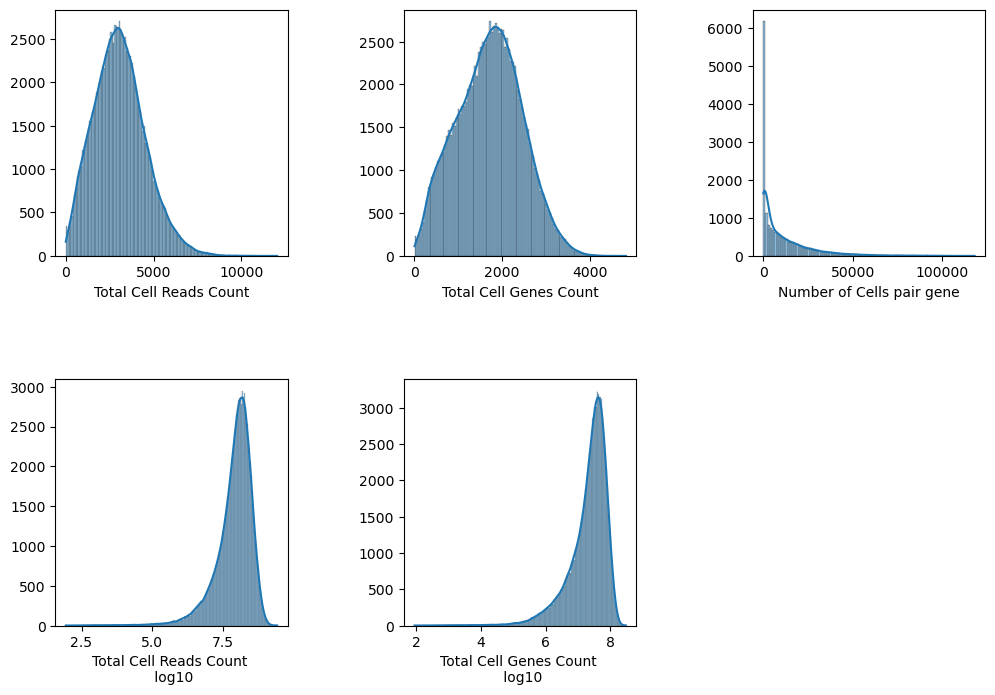

In [9]:
import warnings
# Suppress warnings in this specific code chunk
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    ax = np.ravel(ax)
    plot_dist(andata,column = 'total_counts',ax = ax[0],xlab = 'Total Cell Reads Count')
    plot_dist(andata,column = 'n_genes_by_counts',ax = ax[1],xlab = 'Total Cell Genes Count')
    plot_dist(andata,column = 'n_cells_by_counts',bins = 'doane', type = 'var', ax = ax[2],xlab = 'Number of Cells pair gene')
    plot_dist(andata,column = 'log1p_total_counts',ax = ax[3],xlab = 'Total Cell Reads Count \n log10')
    plot_dist(andata,column = 'log1p_n_genes_by_counts',ax = ax[4],xlab = 'Total Cell Genes Count \n log10')
    ax[5].axis('off')
    plt.subplots_adjust(wspace = 0.5, hspace=0.5)

In [10]:
plt.rcParams['figure.dpi'] = 600
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
fig, ax = plt.subplots(1,1, figsize=(15, 15))
with PdfPages(os.path.join(pathout, 'BreastCancer_58age_Report_spatial_map_plot_total_count.pdf')) as pdf:
    plot_spatial_data(andata, 'total_counts', fig = fig , ax = ax ,set_xlabel_cbar = 'Total Count',size = 1)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
    pdf.savefig()
    plt.close()   

In [11]:
andata

AnnData object with n_obs × n_vars = 119082 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts'
    uns: 'spatial', 'config'
    obsm: 'spatial'

In [12]:
rsc.pp.filter_cells(andata, min_count=50,qc_var = 'total_counts')
rsc.pp.filter_genes(andata, min_count=50,qc_var = 'total_counts')
rsc.pp.filter_genes(andata, max_count=50_000)
andata.layers['counts'] = andata.X.copy()
rsc.pp.normalize_total(andata)
rsc.pp.log1p(andata)
andata.layers['log'] = andata.X.copy()
rsc.pp.highly_variable_genes(andata, n_top_genes=2000, flavor="seurat_v3", layer="log")
andata = andata[:, andata.var["highly_variable"]]
rsc.pp.scale(andata, max_value=10)
rsc.pp.pca(andata, n_comps=30,random_state=1337, use_highly_variable=False)

filtered out 217 cells
filtered out 3183 genes based on total_counts
filtered out 596 genes based on n_cells_by_counts


/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/rapids_singlecell/preprocessing/_hvg.py:517: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/rapids_singlecell/preprocessing/_scale.py:71: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


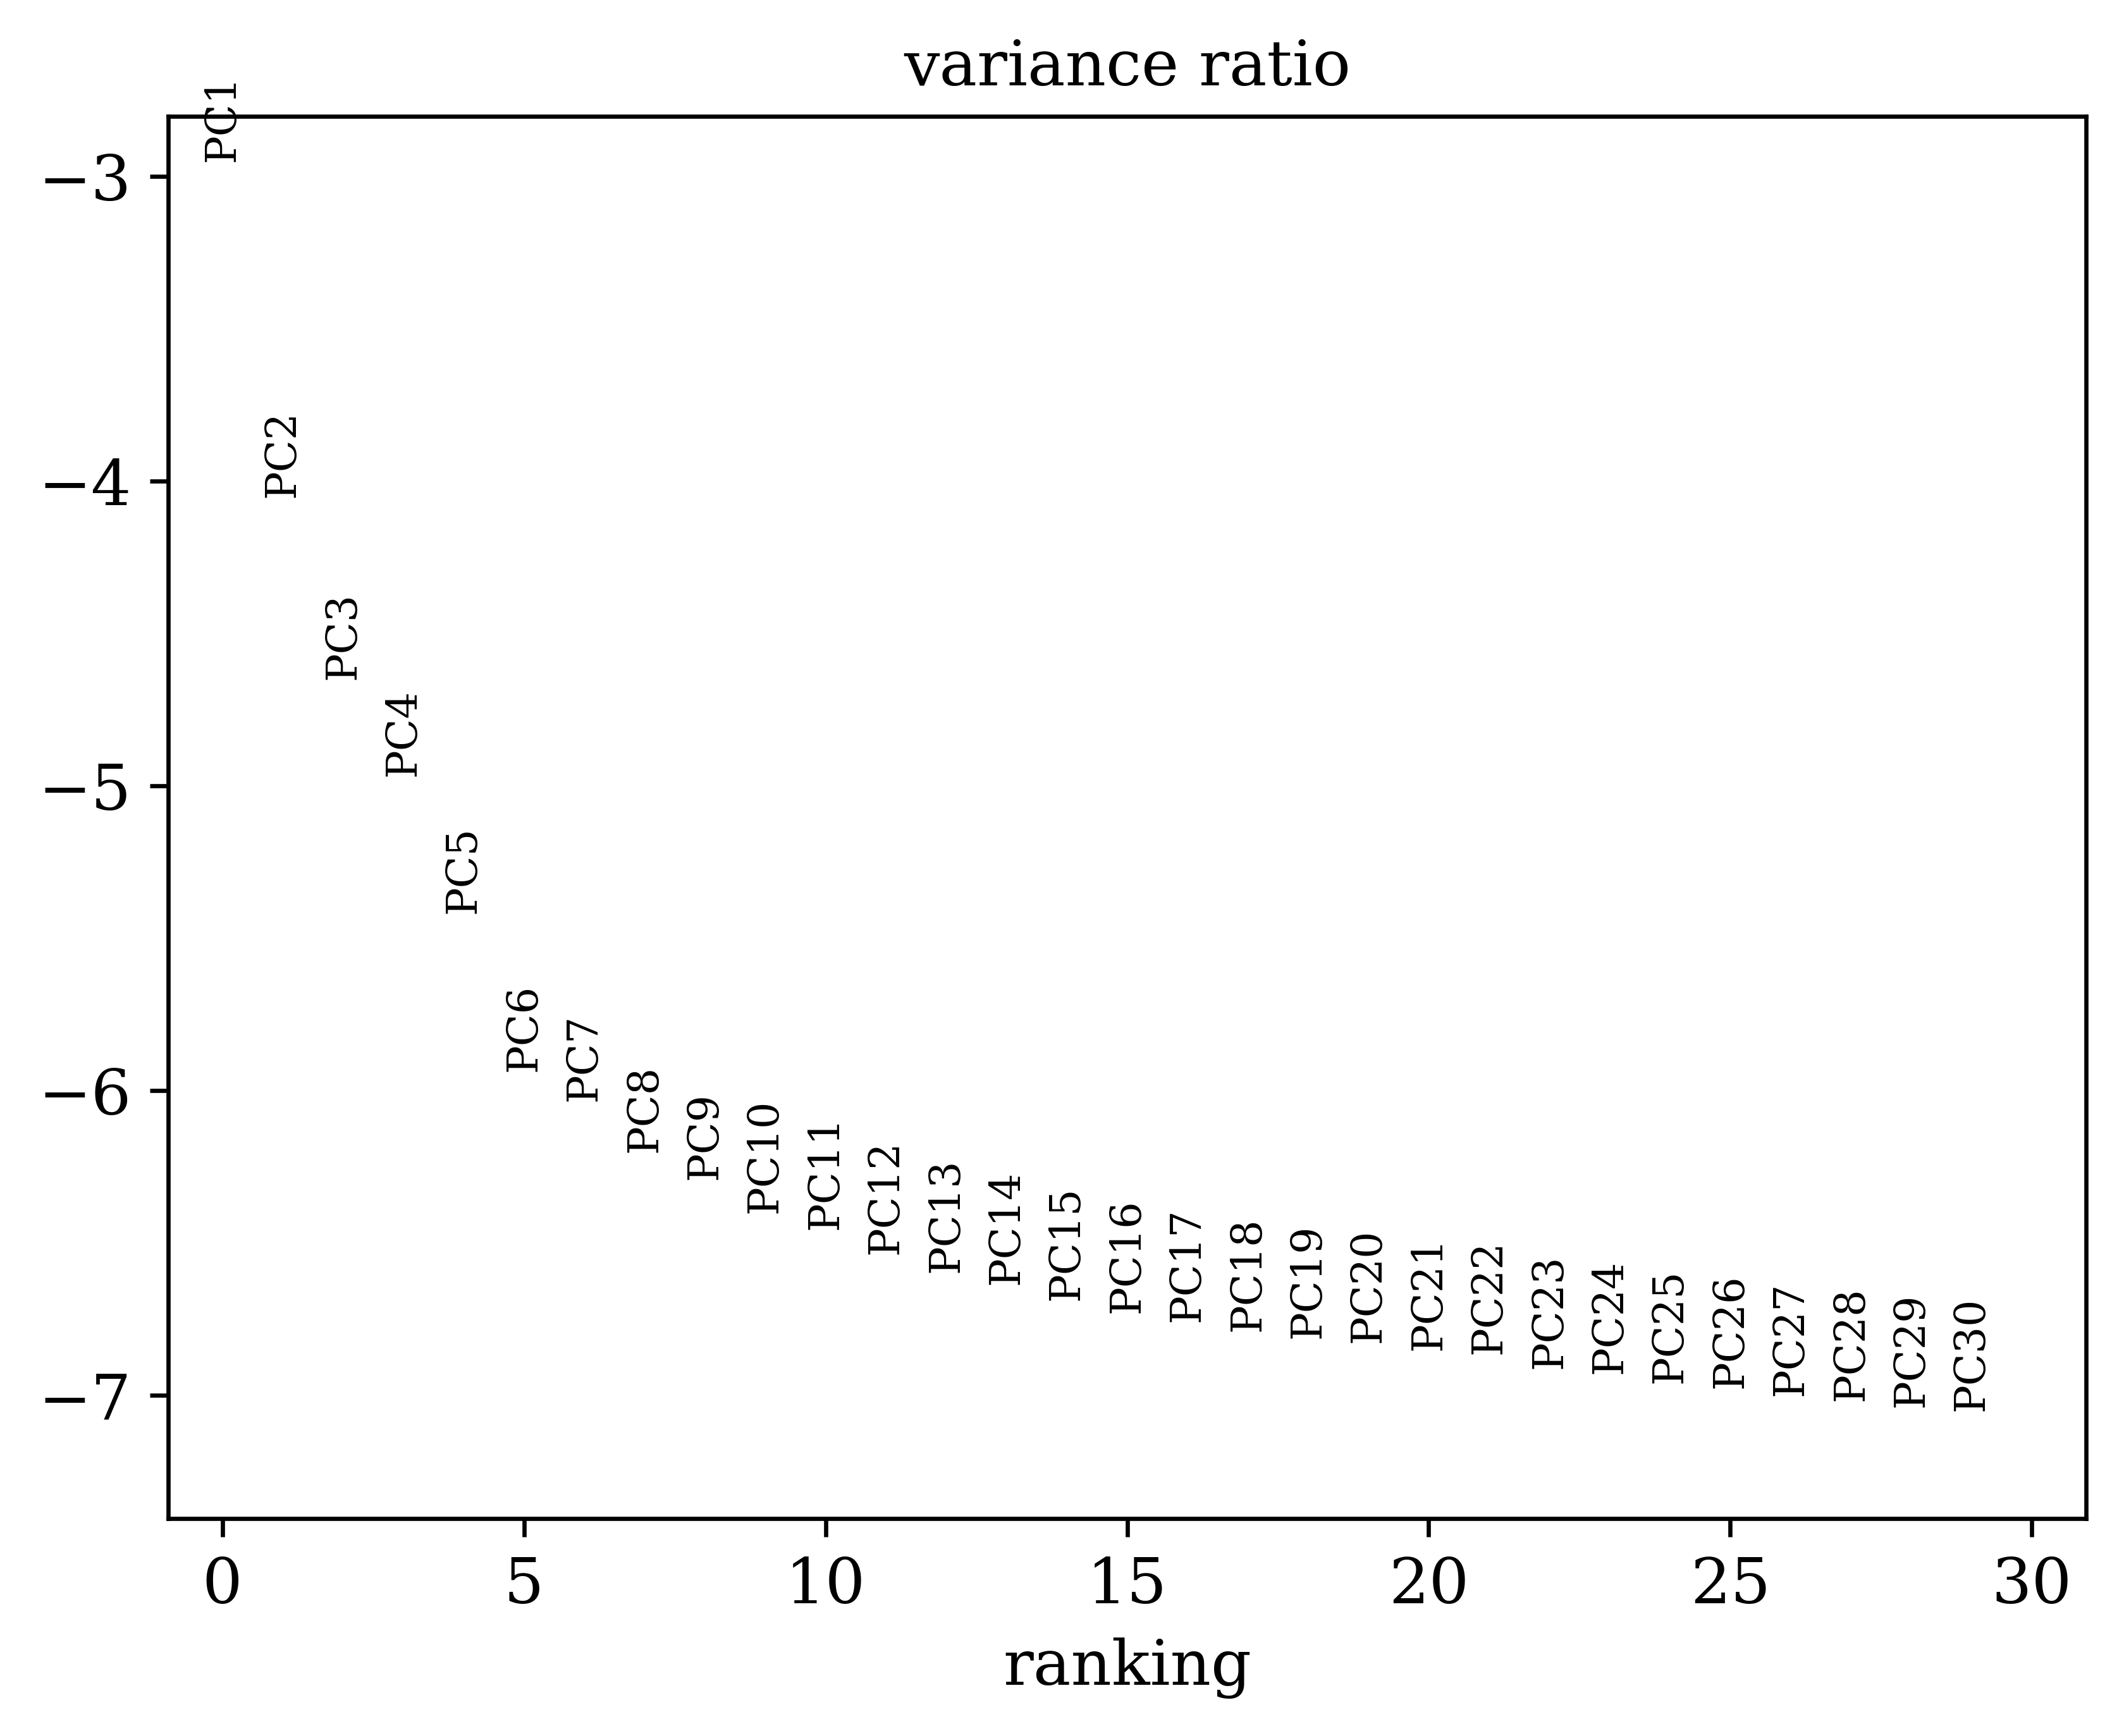

In [13]:
sc.pl.pca_variance_ratio(andata, log=True, n_pcs=30)

In [14]:
rsc.pp.neighbors(andata, n_pcs=15, use_rep='X_pca', n_neighbors=25)

In [15]:
resolutions = [0.5,0.8,1,2]
for res in resolutions:
    rsc.tl.leiden(andata, random_state=1337, resolution=res, key_added='cluster')
    with PdfPages(os.path.join(pathout, f'BreastCancer_58age_Report_spatial_map_plot_{res}.pdf')) as pdf:
        fig, ax = plt.subplots(1, 1, figsize=(15,15))
        plt.rcParams['figure.dpi'] = 600
        plt.rcParams['font.family'] = ['serif']
        plt.rcParams['font.size'] = 12
        plt.rcParams['axes.labelsize'] = 12
        plt.rcParams['axes.titlesize'] = 12
        plt.rcParams['xtick.labelsize'] = 12
        plt.rcParams['ytick.labelsize'] = 12
        clusterColorMap = plot_spatial(andata,ax = ax, features = None, title = f'resolution: {res}',markerscale = 5, xlab = '',ylab ='',size = 0.4)
        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
        pdf.savefig()
        plt.close()
    print(f'{res}')

0.5
0.8
1
2


In [16]:
from cupyx.scipy.sparse import csr_matrix
def save_matrix(matrix,pathout,file_name = "obsp_distances_large.npz"):
    cp.savez(os.path.join(pathout, file_name),  
            data=matrix.data,  
            indices=matrix.indices,  
            indptr=matrix.indptr,  
            shape=matrix.shape)
sparse_matrix = andata.obsp['distances']
save_matrix(matrix = sparse_matrix,pathout = pathout,file_name = "obsp_distances_BreastCancer_58age.npz")
sparse_matrix = andata.obsp['connectivities']
save_matrix(matrix = sparse_matrix,pathout = pathout,file_name = "obsp_connectivities_BreastCancer_58ageF.npz")

In [17]:
andata_save = andata.copy()
for column in andata_save.obs.columns:
    print(f"Column '{column}' has data type: {andata_save.obs[column].dtype}")

Column 'in_tissue' has data type: int64
Column 'array_row' has data type: int64
Column 'array_col' has data type: int64
Column 'n_genes_by_counts' has data type: int32
Column 'total_counts' has data type: float32
Column 'log1p_n_genes_by_counts' has data type: float64
Column 'log1p_total_counts' has data type: float32
Column 'total_counts_MT' has data type: float32
Column 'pct_counts_MT' has data type: float32
Column 'log1p_total_counts_MT' has data type: float32
Column 'cluster' has data type: category


In [18]:
andata_save

AnnData object with n_obs × n_vars = 118865 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'config', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'log'
    obsp: 'distances', 'connectivities'

In [19]:
del andata_save.uns
# del andata_save.obsm
del andata_save.varm
# del andata_save.layers
del andata_save.obsp
andata_save.write_h5ad(os.path.join(pathout, "andata_BreastCancer_58age.h5ad"))

<center>Breast Cancer 58age </center>

In [2]:
path_016 = "/data/kanferg/Sptial_Omics/playGround/Data/Breast_Cancer/age_76/binned_outputs/square_016um"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_4"

In [3]:
def parquet_to_csv(path):
    '''
    Converts a Parquet file to a CSV file if the CSV file does not already exist.
    '''
    file_path = os.path.join(path,'spatial/tissue_positions_list.csv')
    if not os.path.exists(file_path):
        df = pd.read_parquet(os.path.join(path,'spatial/tissue_positions.parquet'))
        # Write to a CSV file
        df.to_csv(os.path.join(path,'spatial/tissue_positions_list.csv'), index=False)
    return
parquet_to_csv(path_016)
andata = sc.read_visium(path=path_016,load_images=False)
positions = pd.read_csv(os.path.join(path_016,'spatial/tissue_positions_list.csv'),index_col=0,)
positions.columns = [
            "in_tissue",
            "array_row",
            "array_col",
            "pxl_col_in_fullres",
            "pxl_row_in_fullres",
        ]
andata.obs = andata.obs.join(positions, how="left")
andata.obsm["spatial"] = andata.obs[
            ["pxl_row_in_fullres", "pxl_col_in_fullres"]
        ].to_numpy()
andata.obs.drop(
    columns=["pxl_row_in_fullres", "pxl_col_in_fullres"],
    inplace=True,
)

/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
rsc.get.anndata_to_GPU(andata)
andata.obsm['spatial'] = np.array(andata.obsm['spatial'], dtype=np.float64)
andata.var_names_make_unique()
andata.uns['config'] = OrderedDict()
andata.uns["config"]["secondary_var_names"] = andata.var_names
rsc.pp.flag_gene_family(andata, gene_family_name="MT", gene_family_prefix="MT-")
rsc.pp.calculate_qc_metrics(andata, qc_vars=["MT"])

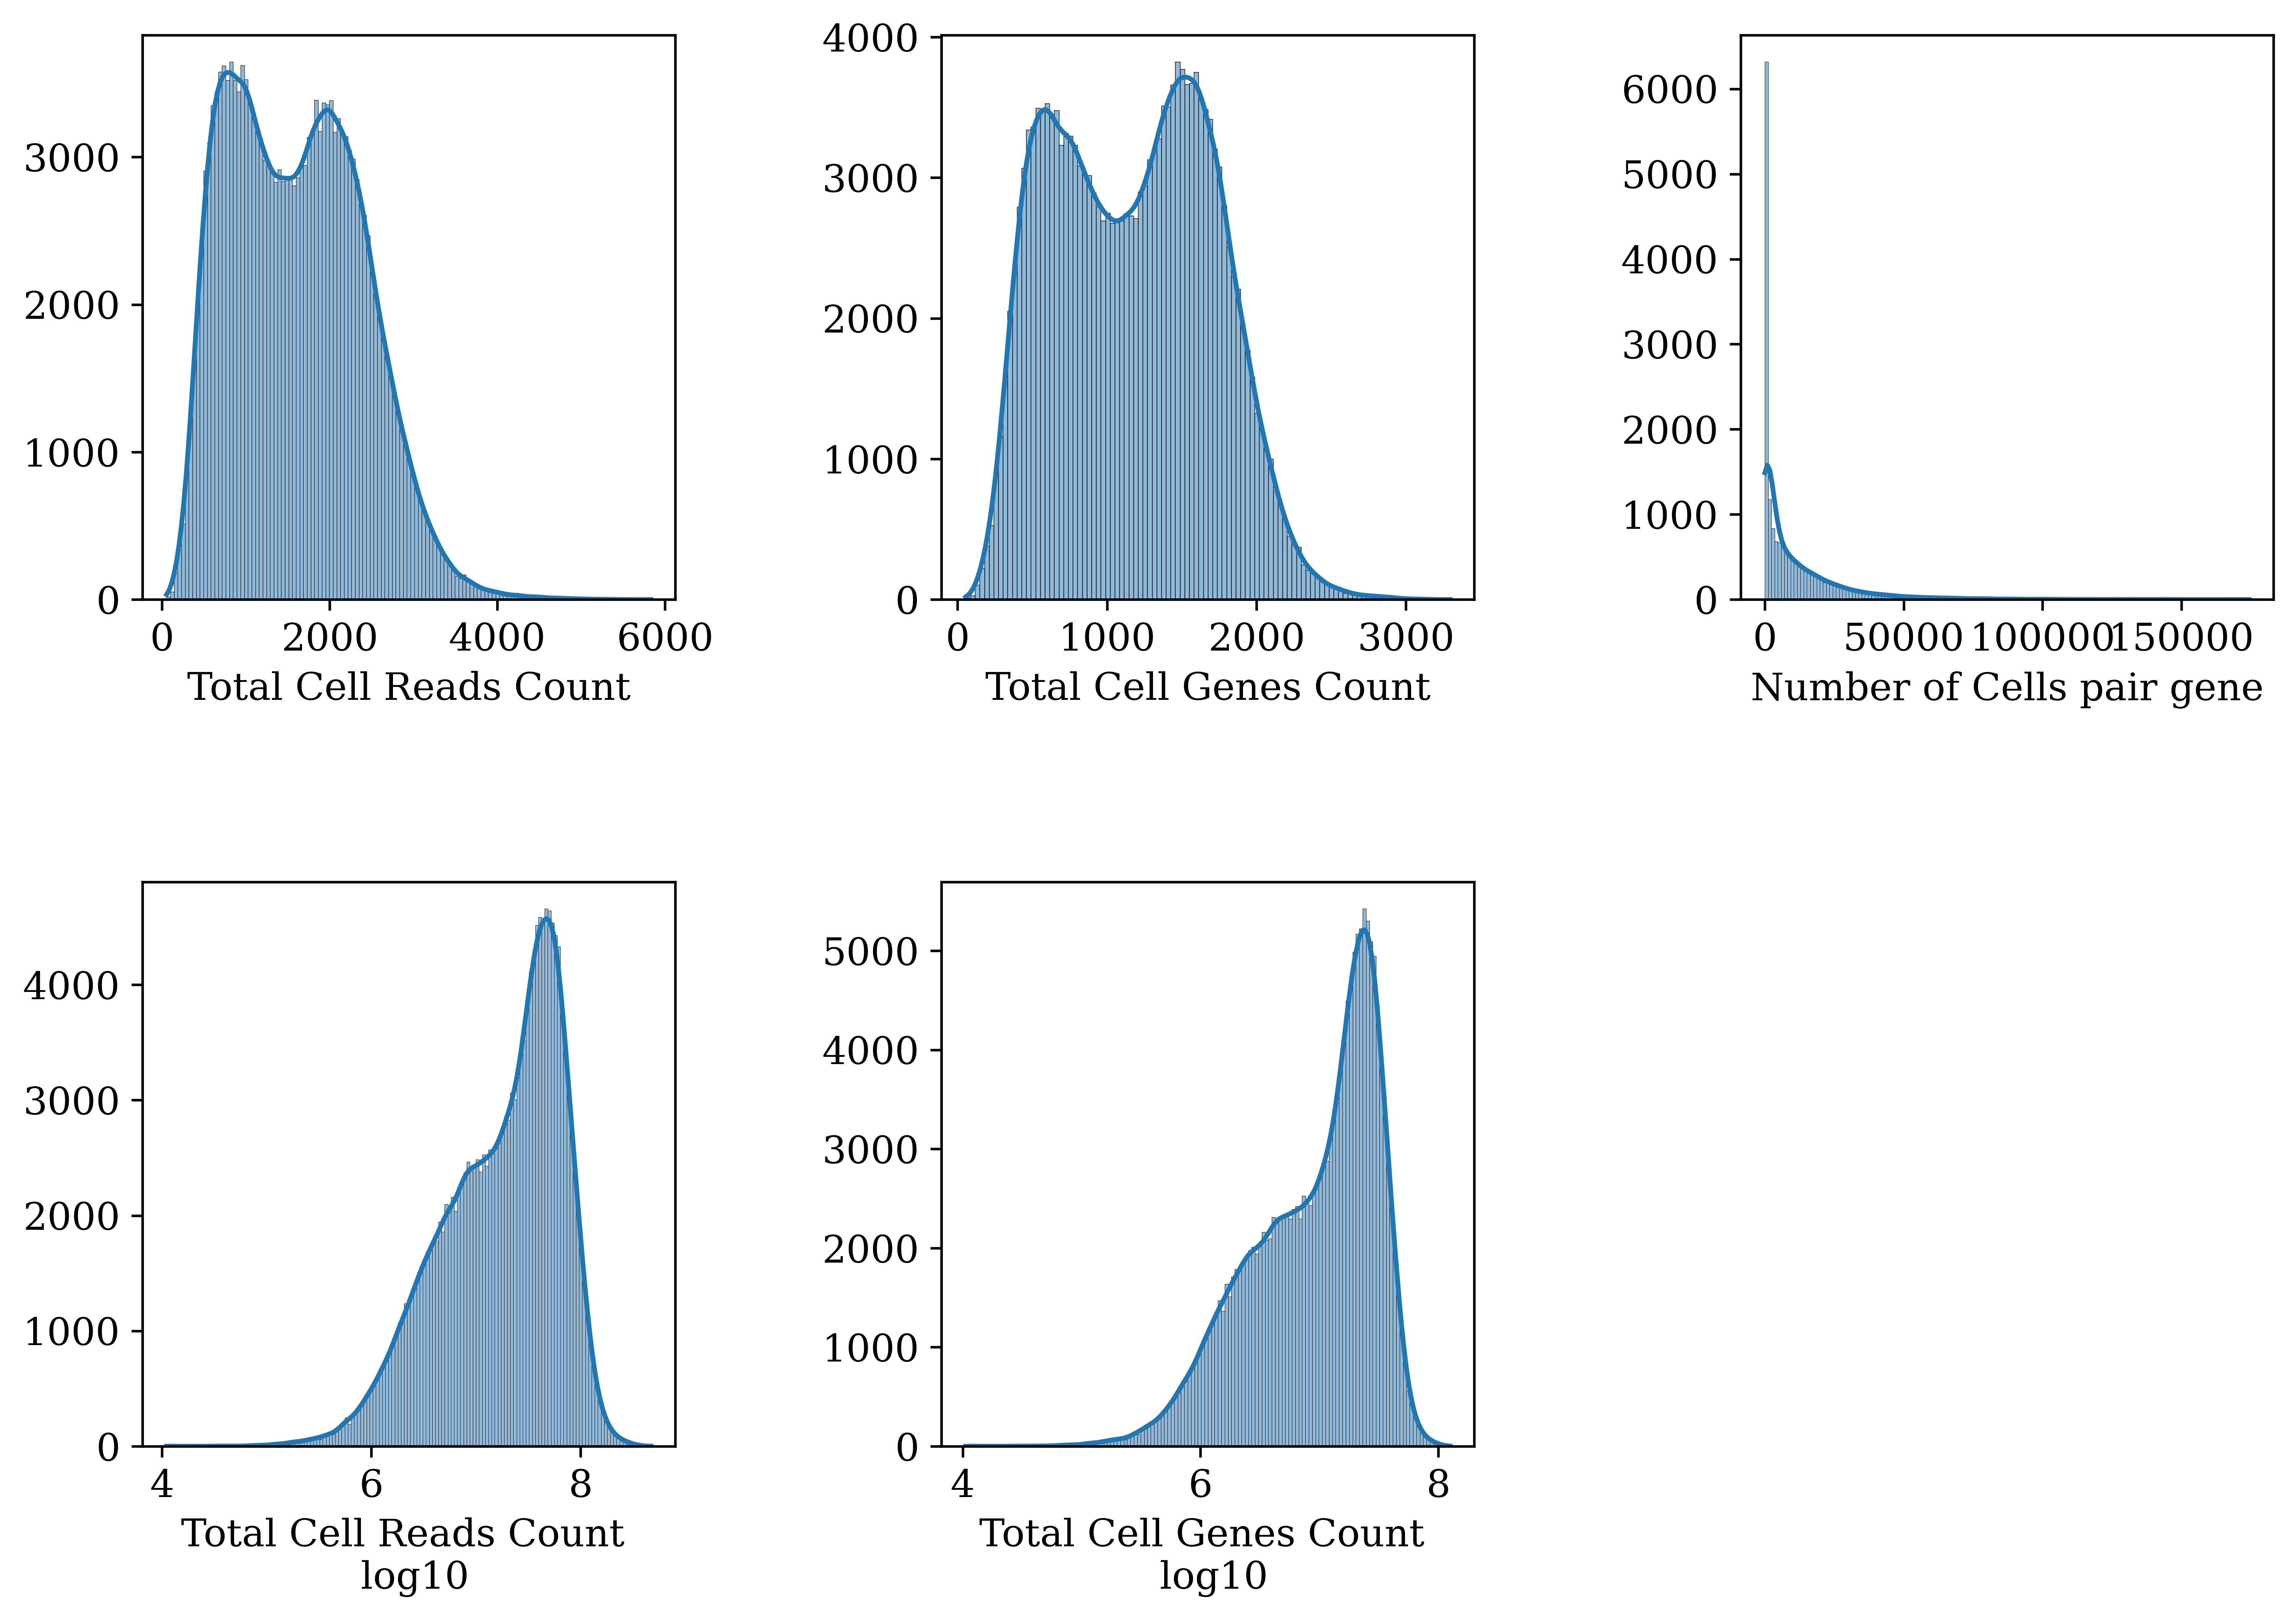

In [31]:
import warnings
# Suppress warnings in this specific code chunk
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    ax = np.ravel(ax)
    plot_dist(andata,column = 'total_counts',ax = ax[0],xlab = 'Total Cell Reads Count')
    plot_dist(andata,column = 'n_genes_by_counts',ax = ax[1],xlab = 'Total Cell Genes Count')
    plot_dist(andata,column = 'n_cells_by_counts',bins = 'doane', type = 'var', ax = ax[2],xlab = 'Number of Cells pair gene')
    plot_dist(andata,column = 'log1p_total_counts',ax = ax[3],xlab = 'Total Cell Reads Count \n log10')
    plot_dist(andata,column = 'log1p_n_genes_by_counts',ax = ax[4],xlab = 'Total Cell Genes Count \n log10')
    ax[5].axis('off')
    plt.subplots_adjust(wspace = 0.5, hspace=0.5)

In [32]:
plt.rcParams['figure.dpi'] = 600
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
fig, ax = plt.subplots(1,1, figsize=(15, 15))
with PdfPages(os.path.join(pathout, 'BreastCancer_76age__Report_spatial_map_plot_total_count.pdf')) as pdf:
    plot_spatial_data(andata, 'total_counts', fig = fig , ax = ax ,set_xlabel_cbar = 'Total Count',size = 1)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
    pdf.savefig()
    plt.close()   

In [5]:
rsc.pp.filter_cells(andata, min_count=50,qc_var = 'total_counts')
rsc.pp.filter_genes(andata, min_count=50,qc_var = 'total_counts')
rsc.pp.filter_genes(andata, max_count=50_000)
andata.layers['counts'] = andata.X.copy()
rsc.pp.normalize_total(andata)
rsc.pp.log1p(andata)
andata.layers['log'] = andata.X.copy()
rsc.pp.highly_variable_genes(andata, n_top_genes=2000, flavor="seurat_v3", layer="log")
andata = andata[:, andata.var["highly_variable"]]
rsc.pp.scale(andata, max_value=10)
rsc.pp.pca(andata, n_comps=30,random_state=1337, use_highly_variable=False)

filtered out 0 cells
filtered out 713 genes based on total_counts
filtered out 689 genes based on n_cells_by_counts


/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/rapids_singlecell/preprocessing/_hvg.py:517: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/rapids_singlecell/preprocessing/_scale.py:71: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


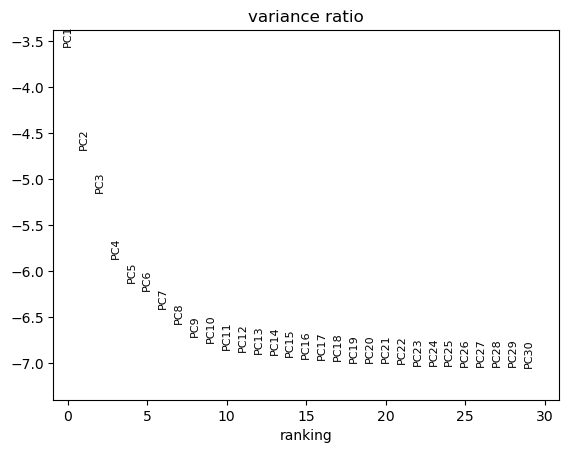

In [6]:
sc.pl.pca_variance_ratio(andata, log=True, n_pcs=30)

In [7]:
rsc.pp.neighbors(andata, n_pcs=15, use_rep='X_pca', n_neighbors=25)

In [9]:
res = 0.5
rsc.tl.leiden(andata, random_state=1337, resolution=0.5, key_added='cluster')
with PdfPages(os.path.join(pathout, f'BreastCancer_76age_Report_spatial_map_plot_{res}.pdf')) as pdf:
    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    plt.rcParams['figure.dpi'] = 600
    plt.rcParams['font.family'] = ['serif']
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    clusterColorMap = plot_spatial(andata,ax = ax, features = None, title = f'resolution: {res}',markerscale = 5, xlab = '',ylab ='',size = 0.4)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
    pdf.savefig()
    plt.close()

In [10]:
from cupyx.scipy.sparse import csr_matrix
def save_matrix(matrix,pathout,file_name = "obsp_distances_large.npz"):
    cp.savez(os.path.join(pathout, file_name),  
            data=matrix.data,  
            indices=matrix.indices,  
            indptr=matrix.indptr,  
            shape=matrix.shape)
sparse_matrix = andata.obsp['distances']
save_matrix(matrix = sparse_matrix,pathout = pathout,file_name = "obsp_distances_BreastCancer_76age.npz")
sparse_matrix = andata.obsp['connectivities']
save_matrix(matrix = sparse_matrix,pathout = pathout,file_name = "obsp_connectivities_BreastCancer_76age.npz")

In [12]:
andata_save = andata.copy()
for column in andata_save.obs.columns:
    print(f"Column '{column}' has data type: {andata_save.obs[column].dtype}")

Column 'in_tissue' has data type: int64
Column 'array_row' has data type: int64
Column 'array_col' has data type: int64
Column 'n_genes_by_counts' has data type: int32
Column 'total_counts' has data type: float32
Column 'log1p_n_genes_by_counts' has data type: float64
Column 'log1p_total_counts' has data type: float32
Column 'total_counts_MT' has data type: float32
Column 'pct_counts_MT' has data type: float32
Column 'log1p_total_counts_MT' has data type: float32
Column 'cluster' has data type: category


In [13]:
andata_save

AnnData object with n_obs × n_vars = 175095 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'config', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'log'
    obsp: 'distances', 'connectivities'

In [14]:
del andata_save.uns
# del andata_save.obsm
del andata_save.varm
# del andata_save.layers
del andata_save.obsp
andata_save.write_h5ad(os.path.join(pathout, "andata_BreastCancer_76age.h5ad"))

<center><H1>Harmony

source mycond
<br>
mamba activate stlearn-env
<br>
jupyter notebook --ip localhost --port $PORT1 --no-browser 

In [1]:
import cupy as cp
import cupyx
import scanpy as sc
import stlearn as st
import scanpy as sc
import numpy as np
from cupyx.scipy.sparse import csr_matrix
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import random
import pandas as pd

/gpfs/gsfs10/users/kanferg/conda/envs/stlearn-env/lib/python3.8/site-packages/stlearn/tools/microenv/cci/het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


In [2]:
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_4"
andata_IF = sc.read_h5ad(os.path.join(pathout, "andata_BreastCancer_58age.h5ad"))
andata_IF.obs['batch'] = 'yes'
andata_noIF = sc.read_h5ad(os.path.join(pathout, "andata_BreastCancer_76age.h5ad"))
andata_noIF.obs['batch'] = 'no'

In [4]:
adata_concat = andata_IF.concatenate(andata_noIF)
adata_concat.shape

/gpfs/gsfs10/users/kanferg/conda/envs/stlearn-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


(293960, 1094)

In [5]:
sc.pp.pca(adata_concat, n_comps=30, svd_solver='arpack')

In [6]:
meta_data = adata_concat.obs
data_mat = adata_concat.obsm["X_pca"]

In [7]:
import harmonypy as hm
ho = hm.run_harmony(data_mat, meta_data, "batch")

2024-11-07 12:28:03,056 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-07 12:29:02,875 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-07 12:29:05,494 - harmonypy - INFO - Iteration 1 of 10
2024-11-07 12:31:39,886 - harmonypy - INFO - Iteration 2 of 10
2024-11-07 12:34:12,675 - harmonypy - INFO - Iteration 3 of 10
2024-11-07 12:36:46,382 - harmonypy - INFO - Iteration 4 of 10
2024-11-07 12:39:18,327 - harmonypy - INFO - Iteration 5 of 10
2024-11-07 12:41:50,095 - harmonypy - INFO - Iteration 6 of 10
2024-11-07 12:44:24,401 - harmonypy - INFO - Converged after 6 iterations


In [8]:
adata_concat.obsm["X_pca_before"] = adata_concat.obsm["X_pca"]

In [9]:
adata_concat.obsm["X_pca"] = ho.Z_corr.T

In [10]:
adata_concat

AnnData object with n_obs × n_vars = 293960 × 1094
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cluster', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'highly_variable', 'n_cells_by_counts-0', 'total_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'log1p_total_counts-0', 'log1p_mean_counts-0', 'highly_variable_rank-0', 'means-0', 'variances-0', 'variances_norm-0', 'mean-0', 'std-0', 'n_cells_by_counts-1', 'total_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'log1p_total_counts-1', 'log1p_mean_counts-1', 'highly_variable_rank-1', 'means-1', 'variances-1', 'variances_norm-1', 'mean-1', 'std-1'
    uns: 'pca'
    obsm: 'X_pca', 'spatial', 'X_pca_before'
    varm: 'PCs'
    layers: 'counts', 'log'

In [11]:
sc.pp.neighbors(adata_concat, n_pcs = 15, use_rep =  "X_pca_before",key_added = 'before')
sc.tl.leiden(adata_concat, random_state=1337, resolution=0.5, key_added='cluster', neighbors_key='before')
adata_concat

2024-11-07 12:48:10.517104: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


AnnData object with n_obs × n_vars = 293960 × 1094
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cluster', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'highly_variable', 'n_cells_by_counts-0', 'total_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'log1p_total_counts-0', 'log1p_mean_counts-0', 'highly_variable_rank-0', 'means-0', 'variances-0', 'variances_norm-0', 'mean-0', 'std-0', 'n_cells_by_counts-1', 'total_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'log1p_total_counts-1', 'log1p_mean_counts-1', 'highly_variable_rank-1', 'means-1', 'variances-1', 'variances_norm-1', 'mean-1', 'std-1'
    uns: 'pca', 'before', 'leiden'
    obsm: 'X_pca', 'spatial', 'X_pca_before'
    varm: 'PCs'
    layers: 'counts', 'log'
    obsp: 'before_distances', 'before_connectivities'

In [12]:
sc.tl.umap(adata_concat, neighbors_key="before")

In [13]:
adata_concat.obsm["X_before_umap"] = adata_concat.obsm["X_umap"]
del adata_concat.obsm["X_umap"]

In [14]:
plt.cm.get_cmap('Set2', 2).colors

/tmp/ipykernel_4011301/2677651987.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.cm.get_cmap('Set2', 2).colors


array([[0.4       , 0.76078431, 0.64705882, 1.        ],
       [0.70196078, 0.70196078, 0.70196078, 1.        ]])

In [15]:
def plot_umap(andata,X_umap_label,column,ax,s = 0.005,paletteSel = None, specColor = None, colorbar = True):
    umap_coords = andata.obsm[X_umap_label]  # assuming UMAP coordinates are stored under 'X_umap'
    seurat_clusters = andata.obs[column].astype('category')  # cluster labels under obs
    
    # Convert the categorical clusters to numeric codes for plotting
    cluster_codes = seurat_clusters.cat.codes
    
    # Generate a Seaborn categorical color palette with distinct colors
    num_clusters = len(seurat_clusters.cat.categories)
    if paletteSel:
        palette = plt.cm.get_cmap('Set2', num_clusters)
    else:
        palette = plt.cm.get_cmap('tab20', num_clusters)  # Ensure it's a discrete palette

    # Create a scatter plot with categorical coloring
    if specColor:
        scatter = ax.scatter(umap_coords[:, 0], umap_coords[:, 1], color=specColor, s=s)
    else:
        scatter = ax.scatter(umap_coords[:, 0], umap_coords[:, 1], c=cluster_codes, cmap=palette, s=s)

    #scatter = ax.scatter(umap_coords[:, 0], umap_coords[:, 1], c=cluster_codes, cmap=palette, s=s)
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Add a colorbar with category labels
    if colorbar:
        cbar = plt.colorbar(scatter, ticks=range(num_clusters))
        cbar.set_ticklabels(seurat_clusters.cat.categories)

/tmp/ipykernel_4011301/2137586416.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('tab20', num_clusters)  # Ensure it's a discrete palette
/tmp/ipykernel_4011301/2137586416.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('Set2', num_clusters)


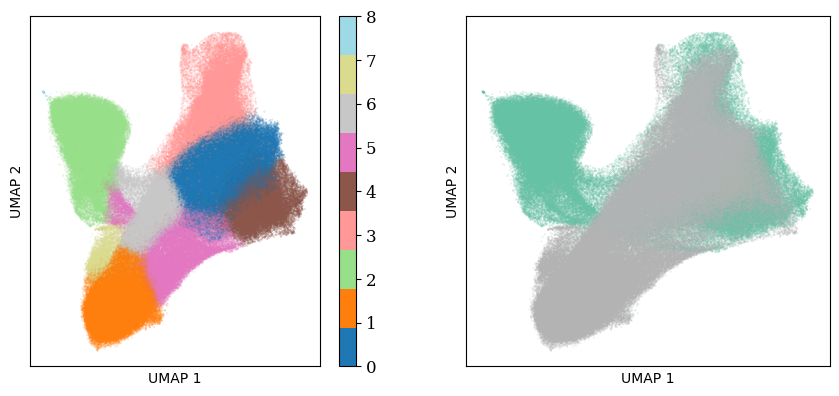

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
plt.rcParams['figure.dpi'] = 92
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plot_umap(adata_concat,X_umap_label = "X_before_umap", column = "cluster",ax = ax[0],s = 0.01)
plot_umap(adata_concat,X_umap_label = "X_before_umap", column = "batch",paletteSel = 'Set2',ax = ax[1],s = 0.01,colorbar = False)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)

/tmp/ipykernel_4011301/4152888978.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plot_umap(ad_yes,X_umap_label = "X_before_umap", column = "batch",paletteSel = None, ax = ax[0],s = 0.01,specColor = plt.cm.get_cmap('Set2', 2)(0),colorbar = False)
/tmp/ipykernel_4011301/2137586416.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('tab20', num_clusters)  # Ensure it's a discrete palette
/tmp/ipykernel_4011301/4152888978.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps

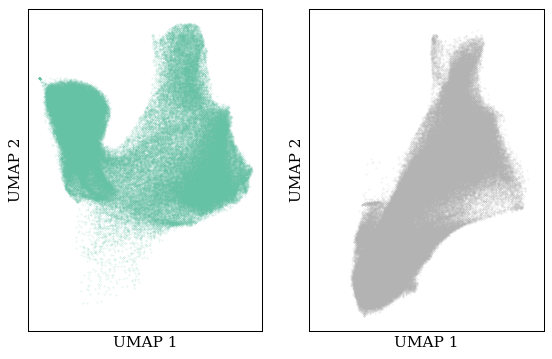

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(7,5),sharex=all,sharey=all)
# plt.rcParams['figure.dpi'] = 92
# plt.rcParams['font.family'] = ['serif']
# plt.rcParams['font.size'] = 12
# plt.rcParams['axes.labelsize'] = 12
# plt.rcParams['axes.titlesize'] = 12
# plt.rcParams['xtick.labelsize'] = 12
# plt.rcParams['ytick.labelsize'] = 12
ad_yes = adata_concat[adata_concat.obs['batch']=="0",:].copy()
plot_umap(ad_yes,X_umap_label = "X_before_umap", column = "batch",paletteSel = None, ax = ax[0],s = 0.01,specColor = plt.cm.get_cmap('Set2', 2)(0),colorbar = False)
ad_yes = adata_concat[adata_concat.obs['batch']=="1",:].copy()
plot_umap(ad_yes,X_umap_label = "X_before_umap", column = "batch",paletteSel = None,ax = ax[1],s = 0.01,specColor = plt.cm.get_cmap('Set2', 2)(1),colorbar = False)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)

Harmony Correction

In [18]:
sc.pp.neighbors(adata_concat, n_pcs = 15, use_rep =  "X_pca",key_added = 'harmony')
sc.tl.leiden(adata_concat, random_state=1337, resolution=0.5, key_added='cluster_harmony', neighbors_key='harmony')
sc.tl.umap(adata_concat, neighbors_key="harmony")
adata_concat.obsm["harmony_umap"] = adata_concat.obsm["X_umap"]
adata_concat

AnnData object with n_obs × n_vars = 293960 × 1094
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cluster', 'batch', 'cluster_harmony'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'highly_variable', 'n_cells_by_counts-0', 'total_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'log1p_total_counts-0', 'log1p_mean_counts-0', 'highly_variable_rank-0', 'means-0', 'variances-0', 'variances_norm-0', 'mean-0', 'std-0', 'n_cells_by_counts-1', 'total_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'log1p_total_counts-1', 'log1p_mean_counts-1', 'highly_variable_rank-1', 'means-1', 'variances-1', 'variances_norm-1', 'mean-1', 'std-1'
    uns: 'pca', 'before', 'leiden', 'umap', 'harmony'
    obsm: 'X_pca', 'spatial', 'X_pca_before', 'X_before_umap', 'X_umap', 'harmony_umap'
    varm: 'PCs'
    layers: 'counts', 'log'
    obsp: 'b

/tmp/ipykernel_4011301/2137586416.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('tab20', num_clusters)  # Ensure it's a discrete palette
/tmp/ipykernel_4011301/2137586416.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('Set2', num_clusters)


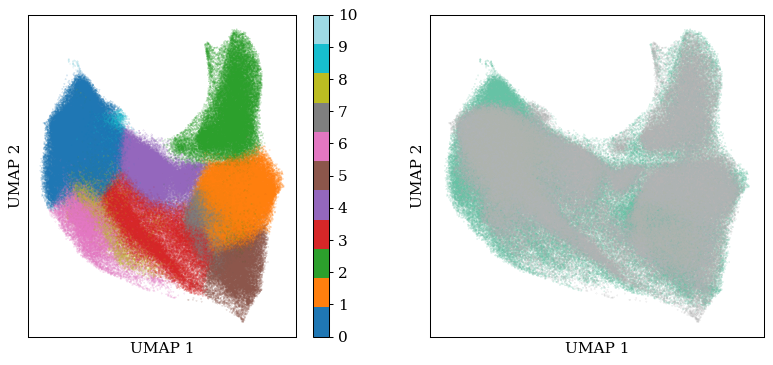

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10,5),sharex=all,sharey=all)
plt.rcParams['figure.dpi'] = 92
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plot_umap(adata_concat,X_umap_label = "harmony_umap", column = "cluster_harmony",ax = ax[0],s = 0.01)
plot_umap(adata_concat,X_umap_label = "harmony_umap", column = "batch",paletteSel = 'Set2',ax = ax[1],s = 0.01, colorbar = False)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)

/tmp/ipykernel_4011301/2858234025.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plot_umap(ad_yes,X_umap_label = "harmony_umap", column = "batch",paletteSel = None,ax = ax[0],s = 0.01,specColor = plt.cm.get_cmap('Set2', 2)(0),colorbar = False)
/tmp/ipykernel_4011301/2137586416.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('tab20', num_clusters)  # Ensure it's a discrete palette
/tmp/ipykernel_4011301/2858234025.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.g

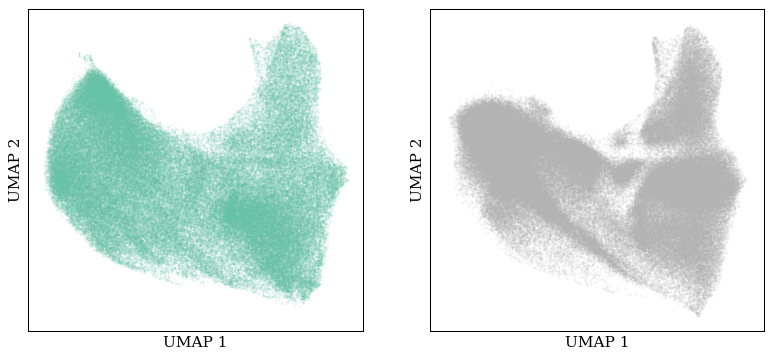

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10,5),sharex=all,sharey=all)
plt.rcParams['figure.dpi'] = 92
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
ad_yes = adata_concat[adata_concat.obs['batch']=="0",:].copy()
plot_umap(ad_yes,X_umap_label = "harmony_umap", column = "batch",paletteSel = None,ax = ax[0],s = 0.01,specColor = plt.cm.get_cmap('Set2', 2)(0),colorbar = False)
ad_yes = adata_concat[adata_concat.obs['batch']=="1",:].copy()
plot_umap(ad_yes,X_umap_label = "harmony_umap", column = "batch",paletteSel = None,ax = ax[1],s = 0.01,specColor = plt.cm.get_cmap('Set2', 2)(1),colorbar = False)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)

In [25]:
from matplotlib.colors import ListedColormap,Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.ticker as ticker

def plot_spatial(andata,ax, cluster = 'cluster', features = None,title = '',xlab = '',ylab ='',size = 2,alpha = 0.6, markerscale = 5, cluster_name = 'cluster'):
    palette = sns.color_palette("tab20") + sns.color_palette("tab20b") + sns.color_palette("tab20c")
    df = pd.DataFrame({'cluster':andata.obs[cluster],'x':andata.obsm['spatial'][:,0],'y':andata.obsm['spatial'][:,1]})
    if features:
        df[df['cluster'].isin([features])]
    num_classes = len(df['cluster'].unique())
    if num_classes==1:
        listed_cmap = ListedColormap(palette)
    else:
        num_classes = len(np.unique(df['cluster'].values))
        extended_palette = palette * (num_classes // len(palette) + 1)
        extended_palette = extended_palette[:num_classes]
        listed_cmap = ListedColormap(extended_palette)
    color_container = []
    
    clusters = sorted(np.unique(df['cluster'].values), key=int)
    for i, cluster in enumerate(clusters):
        cluster_data = df[df['cluster'] == cluster]
        ax.scatter( x=cluster_data['x'], y=cluster_data['y'], color=listed_cmap(i), label=f'{cluster}', s=size, alpha=alpha)
        color_container.append(listed_cmap(i))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    legend = ax.legend( title=cluster_name,
                        bbox_to_anchor=(1.05, 1),  # Position the legend outside the plot
                        loc='upper left',
                        fontsize='small',  # Control the font size
                        title_fontsize='medium',
                        markerscale=markerscale,  # Increase the size of the legend markers
                        frameon=False# Control the title font size
                        )
    df_color = pd.DataFrame({"clusters":df['cluster'].unique(),"colors":color_container})
    return df_color

In [27]:
ad_yes = adata_concat[adata_concat.obs['batch']=="0",:].copy()
with PdfPages(os.path.join(pathout, f'corrected_BreastCancer_76age_Report_spatial_map_plot.pdf')) as pdf:
    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    plt.rcParams['figure.dpi'] = 600
    plt.rcParams['font.family'] = ['serif']
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    clusterColorMap = plot_spatial(ad_yes,cluster = "cluster_harmony",ax = ax, features = None, title = f'',markerscale = 5, xlab = '',ylab ='',size = 0.4)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
    pdf.savefig()
    plt.close()

In [28]:
ad_yes = adata_concat[adata_concat.obs['batch']=="1",:].copy()
with PdfPages(os.path.join(pathout, f'corrected_BreastCancer_58age_Report_spatial_map_plot.pdf')) as pdf:
    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    plt.rcParams['figure.dpi'] = 600
    plt.rcParams['font.family'] = ['serif']
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    clusterColorMap = plot_spatial(ad_yes,cluster = "cluster_harmony",ax = ax, features = None, title = f'',markerscale = 5, xlab = '',ylab ='',size = 0.4)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
    pdf.savefig()
    plt.close()

In [29]:
adata_concat

AnnData object with n_obs × n_vars = 293960 × 1094
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cluster', 'batch', 'cluster_harmony'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'highly_variable', 'n_cells_by_counts-0', 'total_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'log1p_total_counts-0', 'log1p_mean_counts-0', 'highly_variable_rank-0', 'means-0', 'variances-0', 'variances_norm-0', 'mean-0', 'std-0', 'n_cells_by_counts-1', 'total_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'log1p_total_counts-1', 'log1p_mean_counts-1', 'highly_variable_rank-1', 'means-1', 'variances-1', 'variances_norm-1', 'mean-1', 'std-1'
    uns: 'pca', 'before', 'leiden', 'umap', 'harmony'
    obsm: 'X_pca', 'spatial', 'X_pca_before', 'X_before_umap', 'X_umap', 'harmony_umap'
    varm: 'PCs'
    layers: 'counts', 'log'
    obsp: 'b

In [31]:
from cupyx.scipy.sparse import csr_matrix
def save_matrix(matrix,pathout,file_name = "obsp_distances_large.npz"):
    cp.savez(os.path.join(pathout, file_name),  
            data=matrix.data,  
            indices=matrix.indices,  
            indptr=matrix.indptr,  
            shape=matrix.shape)
sparse_matrix = adata_concat.obsp['before_distances']
save_matrix(matrix = sparse_matrix,pathout = pathout,file_name = "obsp_before_distances_bc.npz")
sparse_matrix = adata_concat.obsp['before_connectivities']
save_matrix(matrix = sparse_matrix,pathout = pathout,file_name = "obsp_before_connectivities_bc.npz")
sparse_matrix = adata_concat.obsp['harmony_distances']
save_matrix(matrix = sparse_matrix,pathout = pathout,file_name = "obsp_harmony_distances_bc.npz")
sparse_matrix = adata_concat.obsp['harmony_connectivities']
save_matrix(matrix = sparse_matrix,pathout = pathout,file_name = "obsp_harmony_connectivities_bc.npz")

In [32]:
andata_save = adata_concat.copy()
for column in andata_save.obs.columns:
    print(f"Column '{column}' has data type: {andata_save.obs[column].dtype}")

Column 'in_tissue' has data type: int64
Column 'array_row' has data type: int64
Column 'array_col' has data type: int64
Column 'n_genes_by_counts' has data type: int32
Column 'total_counts' has data type: float32
Column 'log1p_n_genes_by_counts' has data type: float64
Column 'log1p_total_counts' has data type: float32
Column 'total_counts_MT' has data type: float32
Column 'pct_counts_MT' has data type: float32
Column 'log1p_total_counts_MT' has data type: float32
Column 'cluster' has data type: category
Column 'batch' has data type: category
Column 'cluster_harmony' has data type: category


In [33]:
andata_save.write_h5ad(os.path.join(pathout, "adata_concat_BreastCancer_harmony.h5ad"))

## Evaluating Batch Effect Removal and Biological Variance in Data Integration

In the study, different metrics are used to evaluate data integration methods for removing technical (batch) effects while preserving biological variance in single-cell RNA-seq data. Let’s break down the key terms and metrics:

### 1. Biological Variance and Batch Effect Removal
- **Batch Effect Removal**: Corrects for technical noise (differences introduced by processing cells in separate batches) to make data from different batches comparable.
- **Preserving Biological Variance**: Ensures that real, biologically meaningful differences between cells (e.g., cell types or developmental stages) remain intact after batch correction.

### 2. Metrics for Evaluating Integration Quality
- The metrics used in this study fall into two broad categories:
  - **Batch Effect Removal Metrics**: Assess how well the method removes unwanted batch effects.
  - **Biological Variance Conservation Metrics**: Evaluate how well biological variation is retained, so the integration doesn’t "over-correct" and erase meaningful biological differences.

### 3. Label-Free vs. Label Conservation
- **Label Conservation**: This metric checks if cell-type labels or other annotated categories (e.g., stages in a developmental process) are preserved. It uses predefined labels to see if cells of the same type or state remain grouped together after integration.
  - **Example Metrics**: Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) are common label conservation metrics, measuring how well known labels match clusters in the integrated data.
  
- **Label-Free Conservation**: This focuses on conserving aspects of the data that aren't explicitly labeled but are still biologically meaningful.
  - **Example Metrics**:
    - **Trajectory Conservation**: Checks if known developmental or temporal trajectories among cells are retained.
    - **Cell-Cycle Variation**: Measures whether cell-cycle phase-related variation is preserved.
    - **Highly Variable Genes (HVG) Overlap**: Assesses if genes with high expression variability across batches remain variable post-integration.

### How These Metrics Work
- **Label Conservation Metrics** like ARI and NMI use clustering algorithms to check if cells with the same label (e.g., cell type) cluster together in the integrated data. Higher values indicate that cells with the same biological identity remain grouped.
- **Label-Free Metrics** rely on other forms of structure in the data. For example:
  - **Trajectory Conservation**: Looks at how cells in different stages of differentiation align along a path in the integrated data.
  - **Cell-Cycle Variation**: Preserves expression patterns specific to different cell-cycle phases.

These metrics collectively help balance the removal of batch effects with the retention of meaningful biological patterns, ensuring that integration doesn’t lead to loss of important biological signals while still correcting for technical artifacts.

### Reference
This summary is based on the benchmarking study by Luecken et al., 2022. For more details, refer to the full paper: [Benchmarking atlas-level data integration in single-cell genomics](https://doi.org/10.1038/s41592-021-01336-8).
